In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import warnings
from post_processing_multi import * # Import data post processing functions
from plotting_helper import * # Import helper functions for plotting in ipynb
warnings.filterwarnings('ignore') # supress warnings for clenliness

# Loading data
Data is provided in a folder (or series of folders) and is loaded and processed with budget assignment by the ```load_multiple_files_budget``` function. This is wrapped in the load_max_cut_data. This takes a long time due to the large number of files that needs to be processed. If data were stored differently (i.e. in a database), this would be much faster. 

In [5]:

if Path("./MaxCut_runs/filtered_dfk.pkl").is_file():
    maxcut_df=pd.read_pickle('./MaxCut_runs/filtered_df.pkl') 
else:
    maxcut_df = load_all_data() #Only load data from files if there is no database
    maxcut_df.to_pickle('./MaxCut_runs/filtered_df.pkl') 
    maxcut_df.to_csv('./MaxCut_runs/filtered_df.csv')


Qubit: 4, depth: 0, budget:0
Qubit: 4, depth: 0, budget:5
Qubit: 4, depth: 0, budget:6


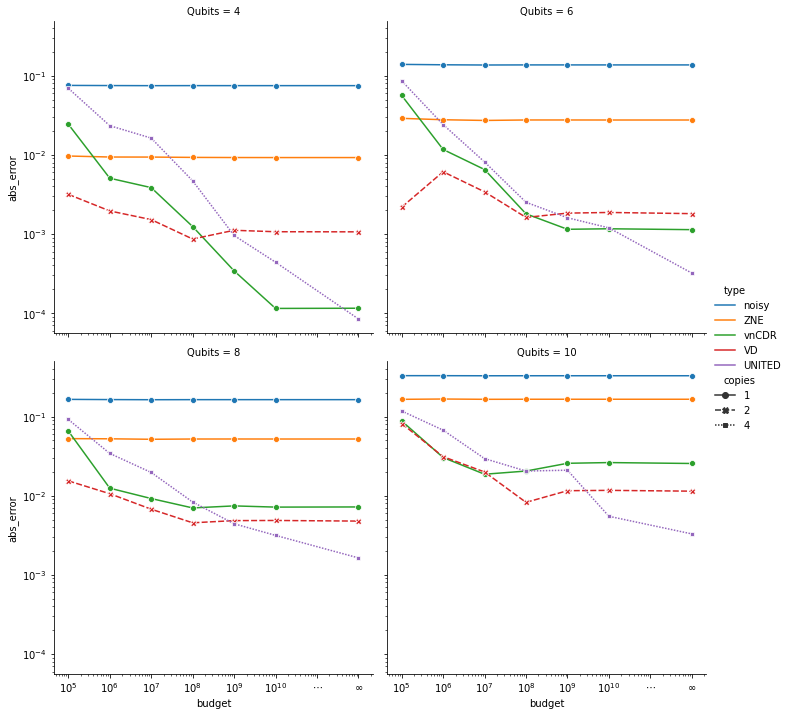

In [3]:
plot_over_budget(maxcut_df)

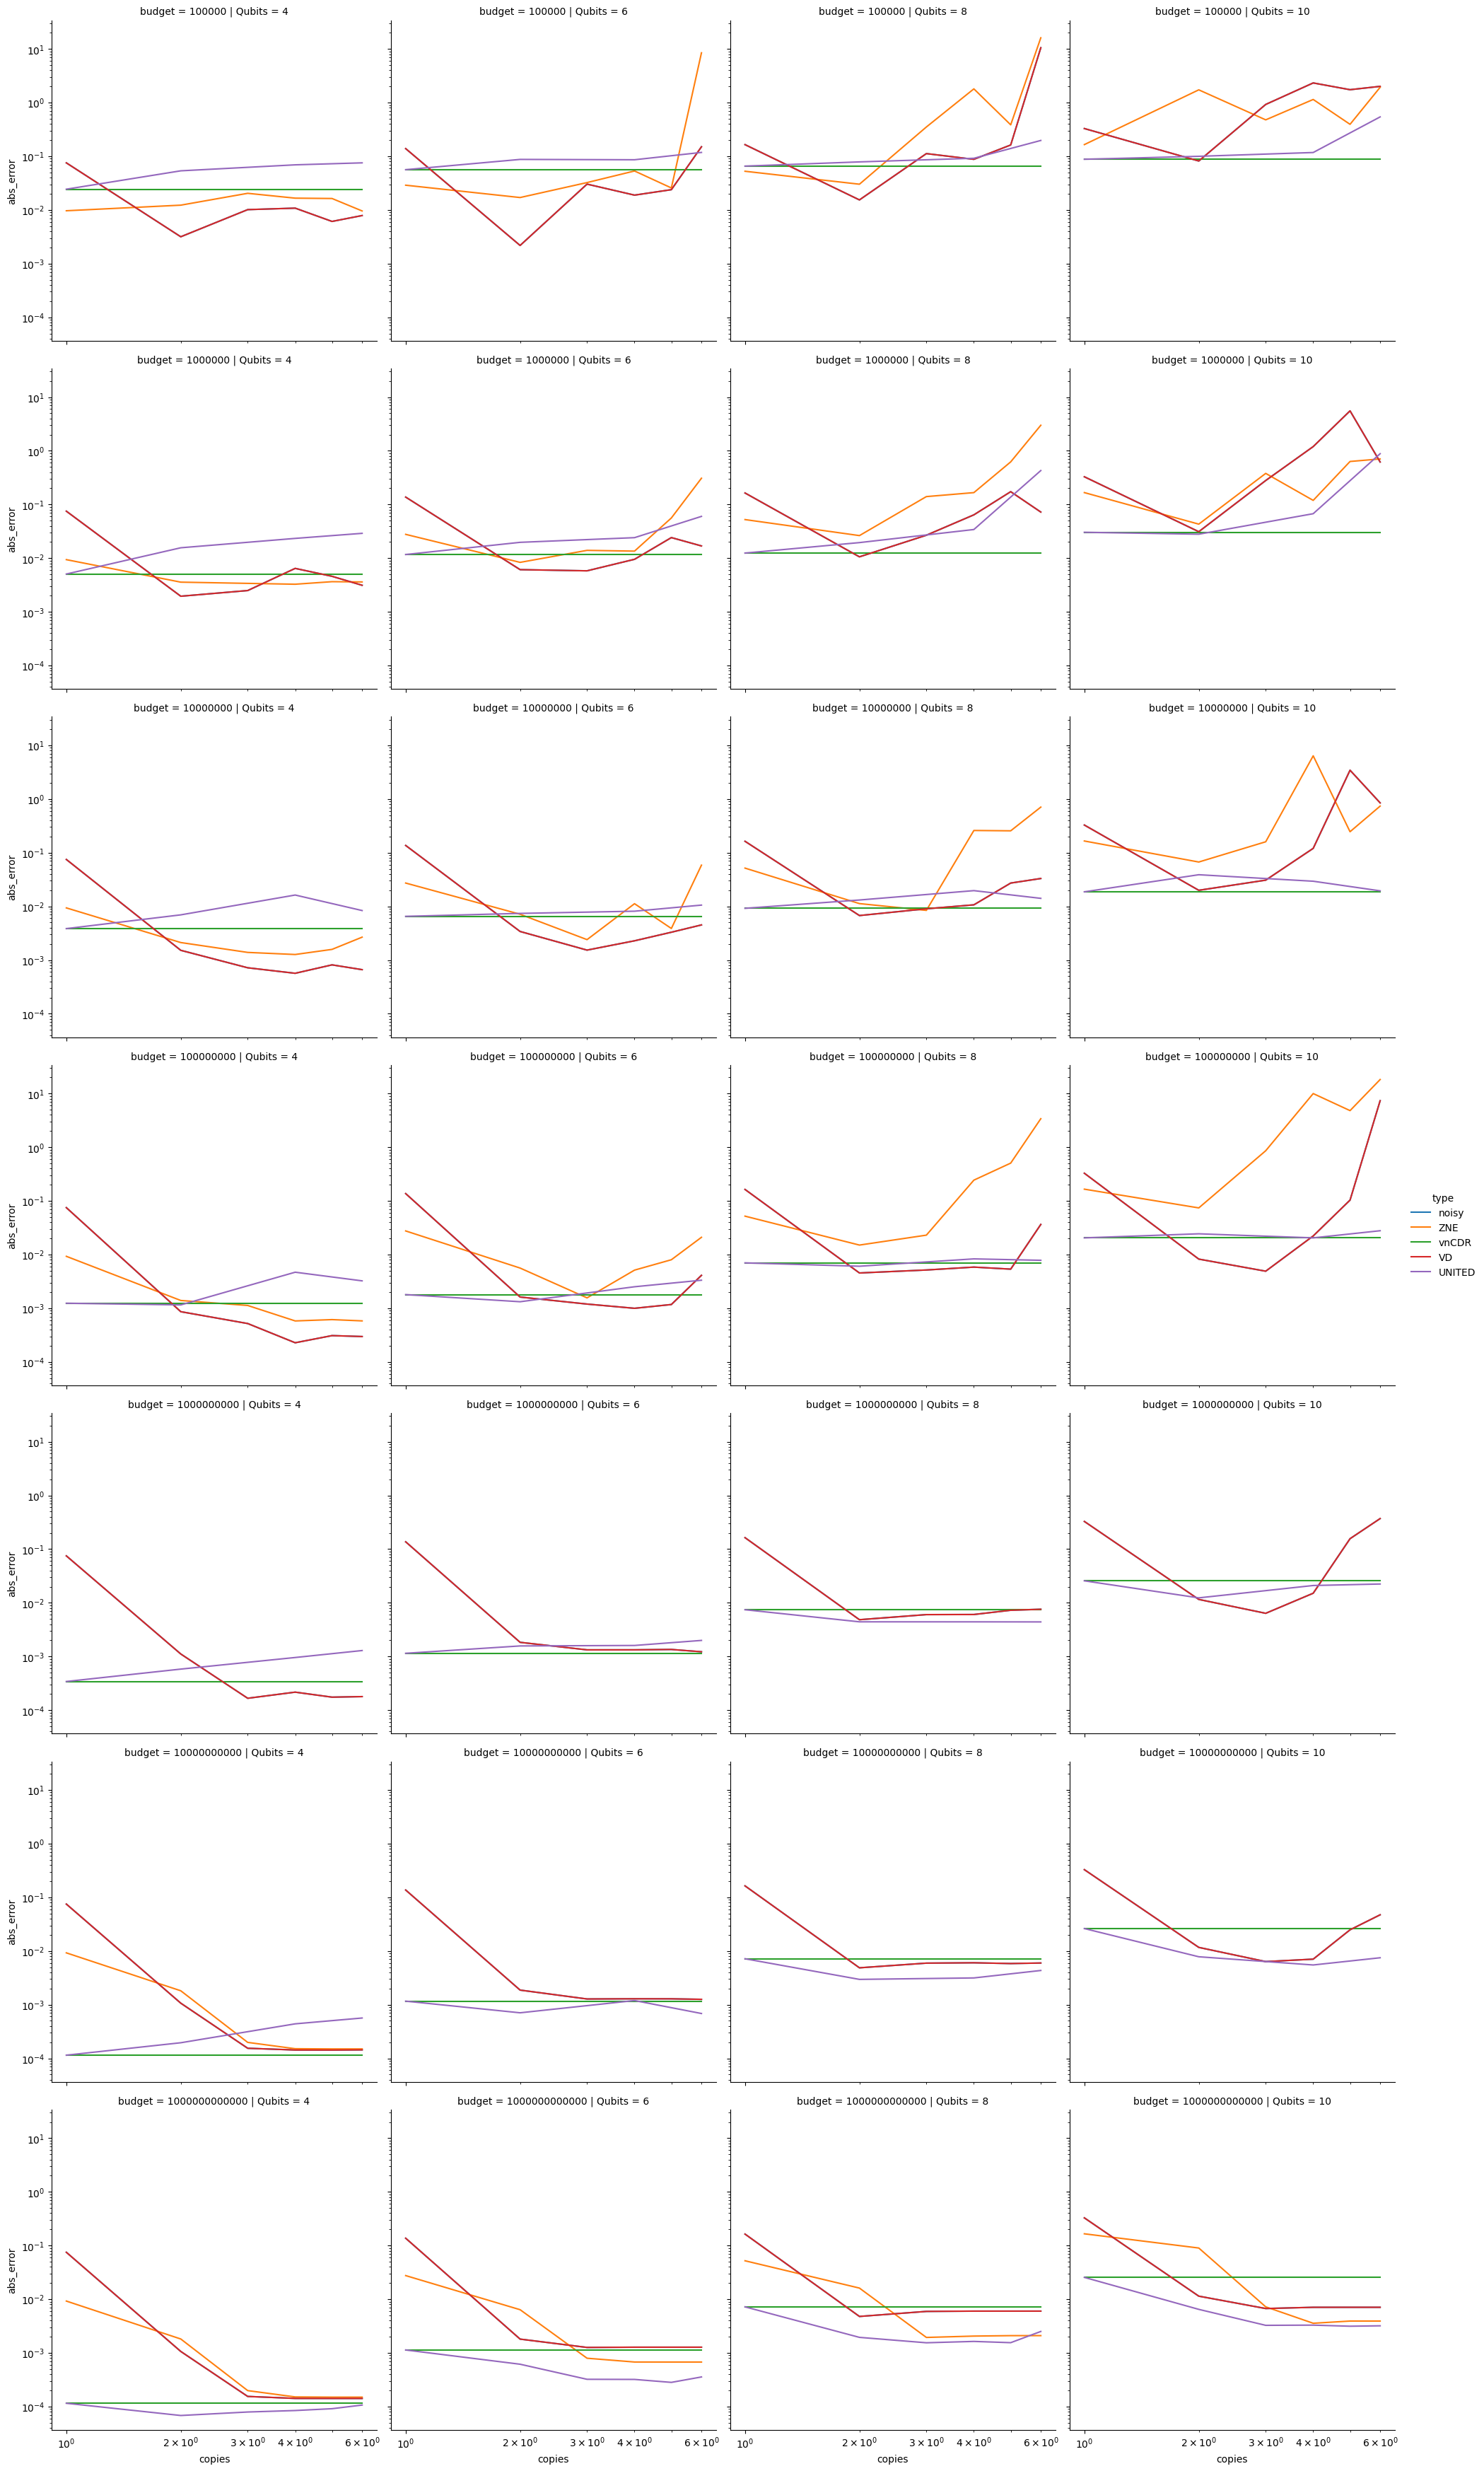

In [4]:
df=maxcut_df
zero_copy_methods = df.query(
    'abs_error > 0   & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type == "ZNE" | type == "vnCDR")'
)
noisy = df.query(
    'abs_error > 0   & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
few_copy_methods = df.query(
    'abs_error >  0  & nlsp==1  & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
many_copy_methods = df.query(
    'abs_error > 0  &nlsp==1  & description == "3nlsp_full" & res_type=="abs_error" & ( type=="UNITED")'
)
noisy["type"] = "noisy"
plot_df = pd.concat(
    [noisy, zero_copy_methods, few_copy_methods, many_copy_methods],
    axis=0,
    ignore_index=True,
)
fig = sns.relplot(
    data=plot_df.reset_index(),
    kind="line",
    x="copies",
    y="abs_error",
    hue="type",
    col="Qubits",
    row='budget',
    estimator="mean",
    markers=True,
    ci=None,
).set(yscale="log", xscale="log")

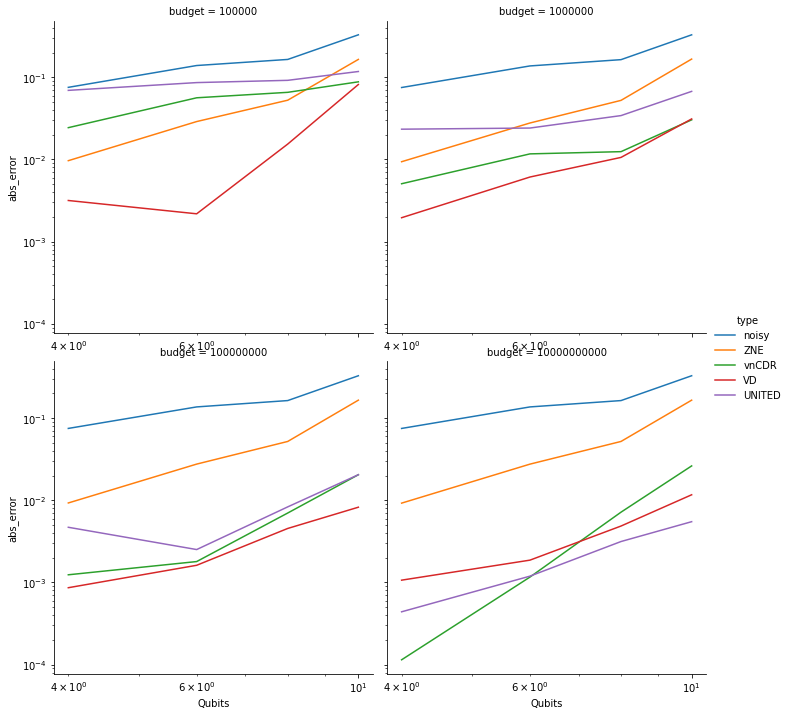

In [16]:
df = maxcut_df.query('budget>0&budget<10**11&budget!=10**9&budget!=10**7')
zero_copy_methods = df.query(
    'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type == "ZNE" | type == "vnCDR")'
)
noisy = df.query(
    'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
few_copy_methods = df.query(
    'abs_error >  0  & nlsp==1 & copies==2 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
many_copy_methods = df.query(
    'abs_error > 0  &nlsp==1  & copies==4& description == "3nlsp_full" & res_type=="abs_error" & ( type=="UNITED")'
)
noisy["type"] = "noisy"
plot_df = pd.concat(
    [noisy, zero_copy_methods, few_copy_methods, many_copy_methods],
    axis=0,
    ignore_index=True,
)
fig = sns.relplot(
    data=plot_df.reset_index(),
    kind="line",
    x="Qubits",
    col='budget',
    col_wrap=2,
    y="abs_error",
    hue="type",
    estimator="mean",
    markers=True,
    ci=None,
).set(yscale="log", xscale='log')

In [28]:
fig3 = plot_df.groupby(['type','Qubits','budget','copies']).aggregate('max').reset_index().drop(['copies','nlsp','depth'],axis=1).reset_index()


In [29]:
fig3.to_csv('./plot_dataframes/fig2_MaxCut_MAX.csv')

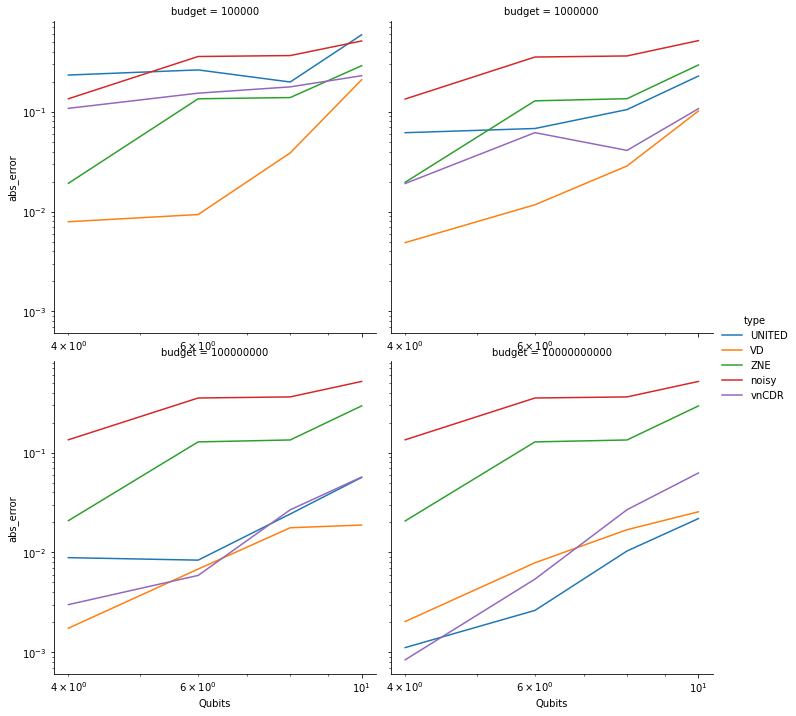

In [30]:
fig = sns.relplot(
    data=fig3.reset_index(),
    kind="line",
    x="Qubits",
    col='budget',
    col_wrap=2,
    y="abs_error",
    hue="type",
    estimator="mean",
    markers=True,
    ci=None,
).set(yscale="log", xscale='log')

In [5]:
import os 
dir_path = 'RQC_runs/all_qubits/'
res = []
for file in os.listdir(dir_path):
    if file.endswith('.pkl'):
        res.append(pd.read_pickle(dir_path+file))
res = pd.concat(res)

In [6]:
res

expectation exact
result_type tag      shots nlsp seed qubits copies                  
train       _LinGrow NaN   1    0    6      1        -0.882719  -1.0
                                            1        -0.908045  -1.0
                                            1         0.884048   1.0
                                            1        -0.877442  -1.0
                                            1         0.890289   1.0
...                                                        ...   ...
                           3    29   6      6              0.0   0.0
                                            6              0.0   0.0
                                            6              0.0   0.0
                                            6              0.0   0.0
                                            6              0.0   0.0

[381780 rows x 2 columns]

In [185]:
import os 
dir_path = 'RQC_runs/all_qubits/'
def quick_load(fi):
    res = []
    files = []
    for file in os.listdir(dir_path):
        if file.endswith('.pkl') and file.startswith(f"pandas_{fi}"):
            res.append(pd.read_pickle(dir_path+file).assign(file=file).assign(data=fi))
            files.append(file)
    res = pd.concat(res)
    res=res.reset_index()
    res = res.reset_index().query('copies==1 & nlsp==1')
    res = res.drop(['shots','result_type','copies'],axis=1)
    res["exact"] = pd.to_numeric(res['exact'])
    res["expectation"] = pd.to_numeric(res['expectation'])
    res["exact_abs"] = np.abs(res['exact'])
    return res

train = quick_load('train')
coi = quick_load('COI')

In [187]:
train.groupby('file')['exact_abs'].describe().reset_index().to_csv('train_quick_stats.csv')
coi.groupby('file')['exact_abs'].describe().reset_index().to_csv('coi_quick_stats.csv')


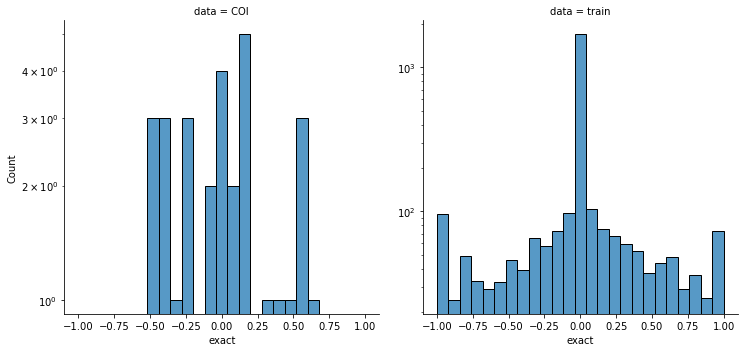

In [195]:
sns.displot(kind='hist',data=pd.concat([coi,train]).query("file.str.contains('4p4')"),x='exact',col='data',col_wrap=4,bins=25,facet_kws=dict(sharey=False)).set(yscale='log')

In [199]:
npcoi = coi.query("file.str.contains('4p4')")['exact'].reset_index()
nptrain = train.query("file.str.contains('4p4')")['exact'].reset_index()

In [200]:

npcoi

,index,exact
0,1080,-0.409489
1,1098,-0.311332
2,1116,-0.113575
3,1134,0.602248
4,1152,0.344694
5,1170,-0.422612
6,1188,-0.014746
7,1206,0.056851
8,1224,0.556058
9,1242,0.131706
